# Did I really explained more? Hypothesis test for R2 change.

This post is a super fast, short, basic statistics tutorial on measuring the change in R2 between two nested model.
Many a times, we want a high R2 score in our regression. This can be done by simply adding predictors into the model, whether they are good predictors or not. Since R2 scores will increase with number of predictors, how do we know when to stop? Is there a test to know when we should stop or which model we should keep?

YES! There are many ways. There are various ways of feature selection, for instance, using a Lasso regularization to automate this. However, today I would like to share an approach that can be used as a way to test covariates as well.

**Why am I writing this article?**
This approach is automatically printed in nested regression models in SPSS. However, I was unable to find a function to calculate this when I started using Python. Thus, I would like to share this article so that you may implement it yourself if you need without having to search all day for a function that doesn't exist, like I did.

**The question that the analysis will answer:**
Did the females receive lower starting salaries than similarly qualified and similarly experienced males.

In [1]:
import numpy as np 
from scipy.stats import zscore, f
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', header=0)
df.head()

,bsal,sal77,senior,age,educ,exper,sex
0,5040.0,12420.0,96.0,329.0,15.0,14.0,1
1,6300.0,12060.0,82.0,357.0,15.0,72.0,1
2,6000.0,15120.0,67.0,315.0,15.0,35.5,1
3,6000.0,16320.0,97.0,354.0,12.0,24.0,1
4,6000.0,12300.0,66.0,351.0,12.0,56.0,1


In [3]:
df = df.rename(columns = {'bsal':'start_sal', 
                     'sal77':'current_sal', 
                     'senior':'seniority', 
                     })

In [4]:
# df['sal_increase'] = df['current_sal'] - df['start_sal']

In [5]:
df.head()

,start_sal,current_sal,seniority,age,educ,exper,sex
0,5040.0,12420.0,96.0,329.0,15.0,14.0,1
1,6300.0,12060.0,82.0,357.0,15.0,72.0,1
2,6000.0,15120.0,67.0,315.0,15.0,35.5,1
3,6000.0,16320.0,97.0,354.0,12.0,24.0,1
4,6000.0,12300.0,66.0,351.0,12.0,56.0,1


In [6]:
df.shape

(93, 7)

# Data Cleaning
## Missing Data

In [7]:
missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)

,feature,unique_values,percent_missing,percent_biggest_cat,type
0,start_sal,26,0.0,18.279570,float64
1,current_sal,62,0.0,5.376344,float64
2,seniority,31,0.0,9.677419,float64
3,age,86,0.0,3.225806,float64
4,educ,5,0.0,52.688172,float64
5,exper,79,0.0,3.225806,float64
6,sex,2,0.0,65.591398,int64


## Outliers

In [8]:
#print out the rows with more than 3sd outlier cut off
#highlight those values in pink 

abs_z_df = df.apply(zscore).abs()
filt = (np.abs(zscore(df)) > 3).any(axis = 1)


abs_z_df[filt].style.apply(lambda x: ["background: pink" if x > 3 else "" for x in x], axis = 1)

,start_sal,current_sal,seniority,age,educ,exper,sex
3,0.821350,3.329843,1.443253,0.863348,0.222626,0.850434,1.380670
6,3.796857,2.015231,1.596118,0.755786,1.539437,0.513256,1.380670
15,0.878940,1.018489,1.541297,2.148384,0.222626,3.096206,0.724286


In [9]:
#lets drop them outliers
out_filter = (np.abs(zscore(df)) < 3).all(axis=1)
df = df[out_filter]

print(df.shape)

(90, 7)


# EDA

In [10]:
df.describe().round(2)

,start_sal,current_sal,seniority,age,educ,exper,sex
count,90.00,90.00,90.00,90.00,90.00,90.00,90.00
mean,5391.00,10307.33,82.12,473.58,12.48,99.19,0.33
std,656.38,1651.41,10.02,137.93,2.29,87.03,0.47
min,3900.00,7860.00,65.00,280.00,8.00,0.00,0.00
25%,4995.00,9000.00,74.25,348.25,12.00,35.62,0.00
50%,5400.00,9930.00,83.50,471.00,12.00,71.00,0.00
75%,6000.00,11205.00,89.00,589.75,15.00,141.12,1.00
max,6900.00,15360.00,98.00,771.00,16.00,359.00,1.00


C:\Users\ice\AppData\Local\Temp\ipykernel_20844\307350242.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


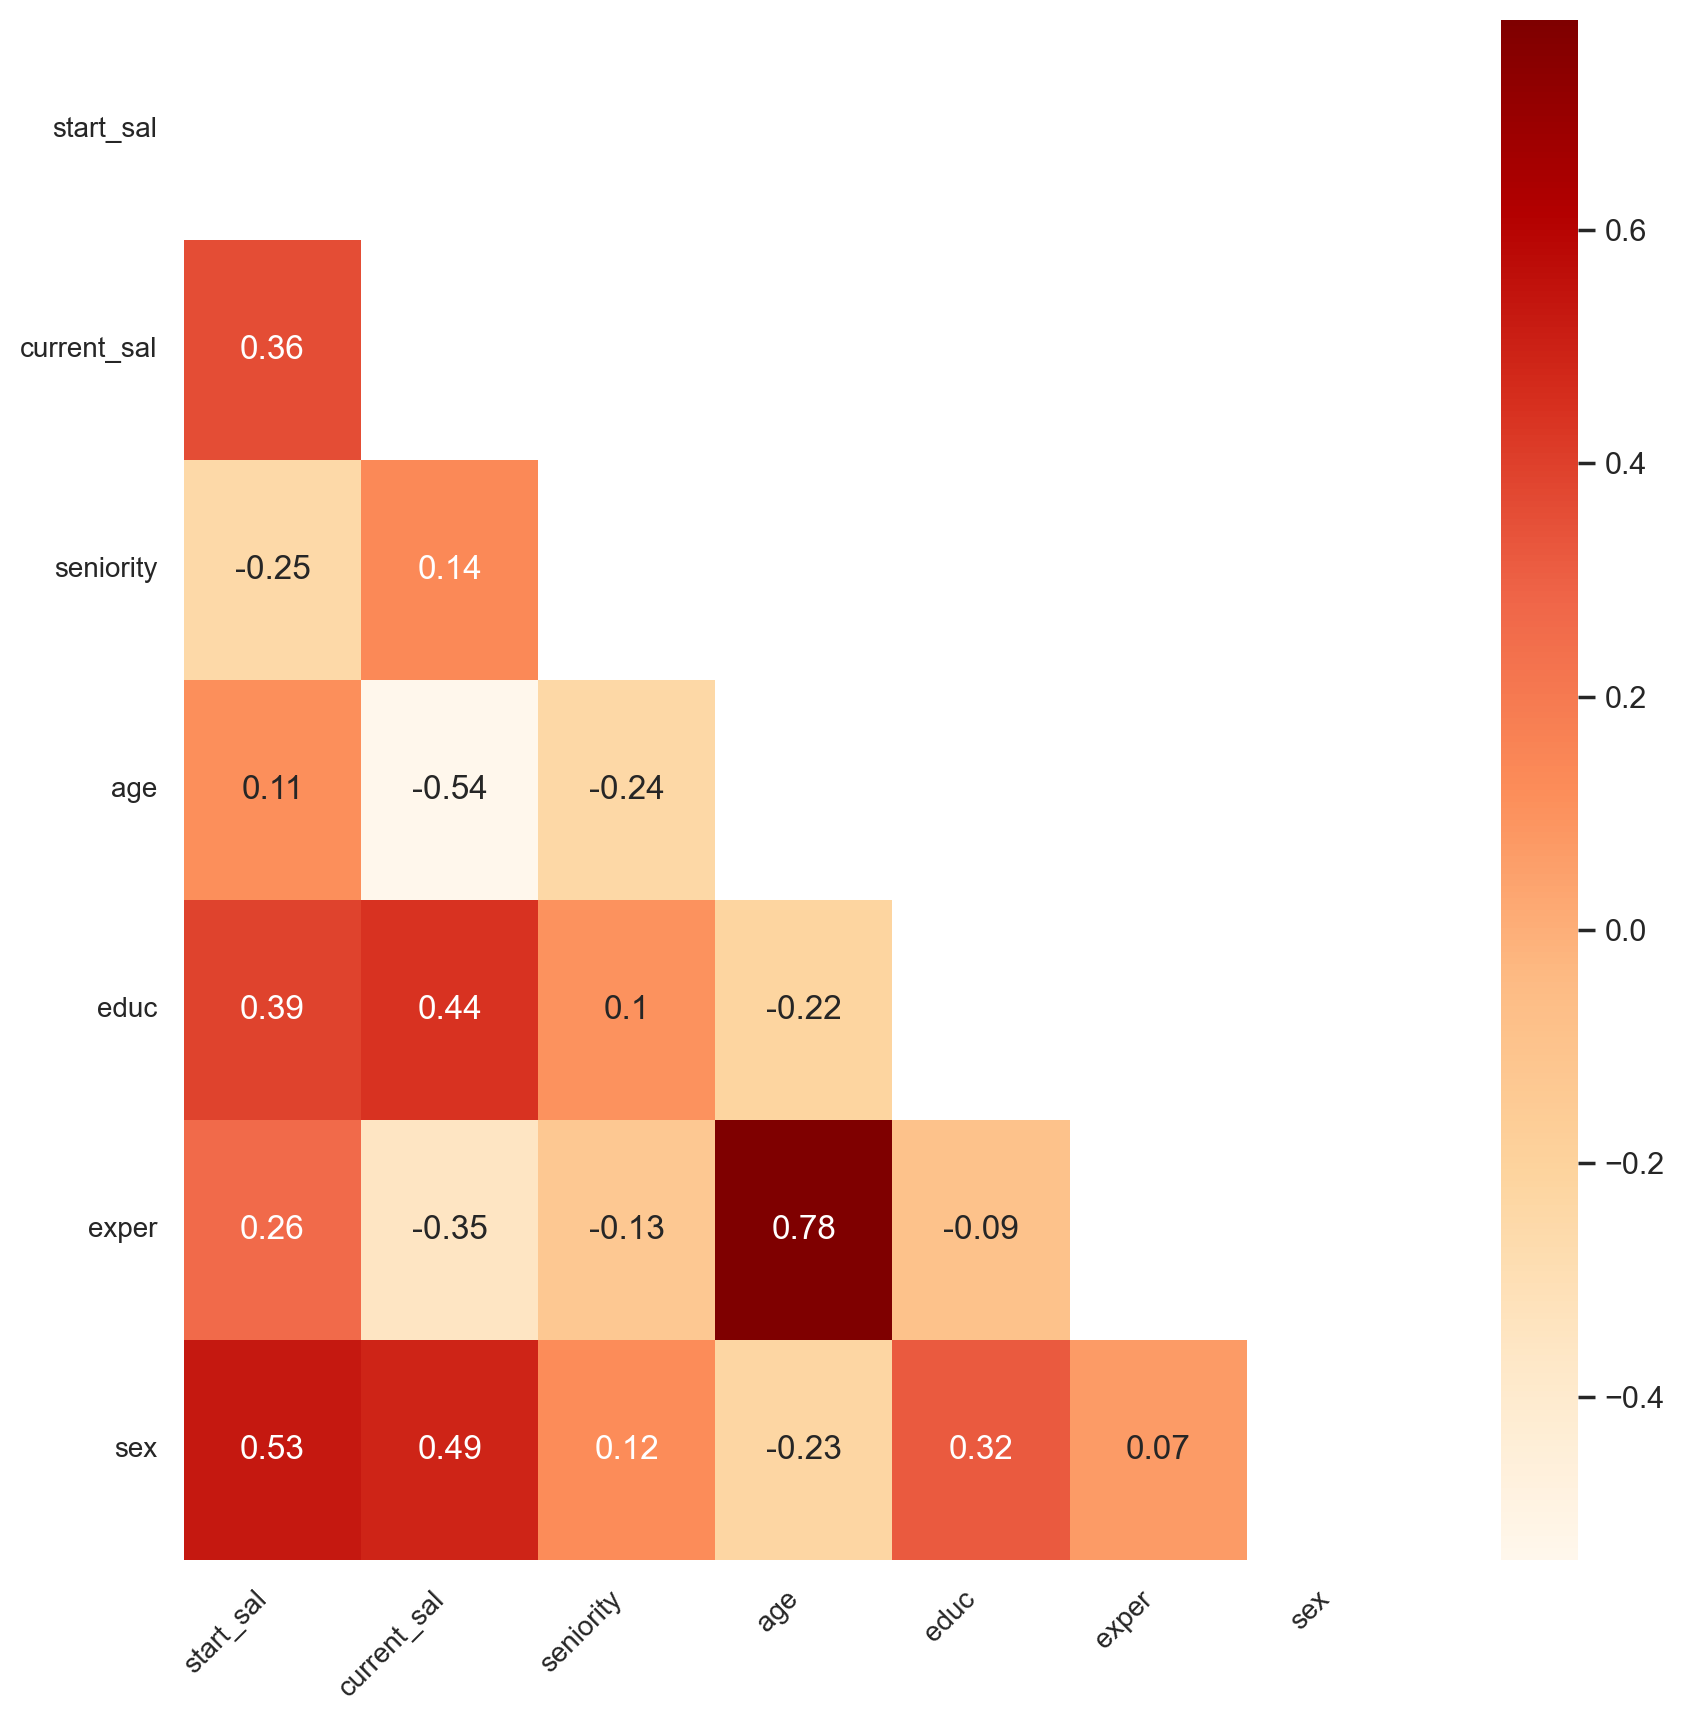

In [11]:
sns.set_style('white')

# heatmap from those with at least 0.3 magnitude in corr, includeing the DV
corr_list=list(df.columns)

corr_df = df[corr_list]
corr=round(corr_df.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

C:\Users\ice\AppData\Local\Temp\ipykernel_20844\3404521076.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[name])
C:\Users\ice\AppData\Local\Temp\ipykernel_20844\3404521076.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[name])
C:\Users\ice\AppData\Local\Temp\ipykernel_20844\340452

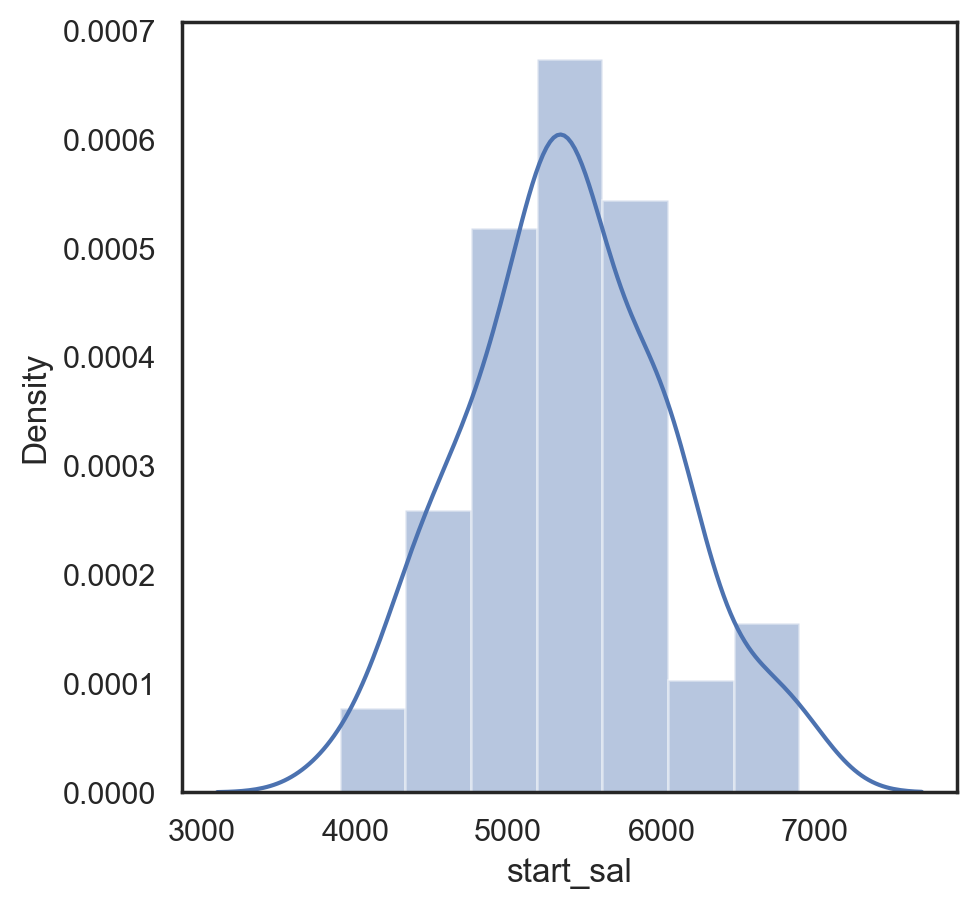

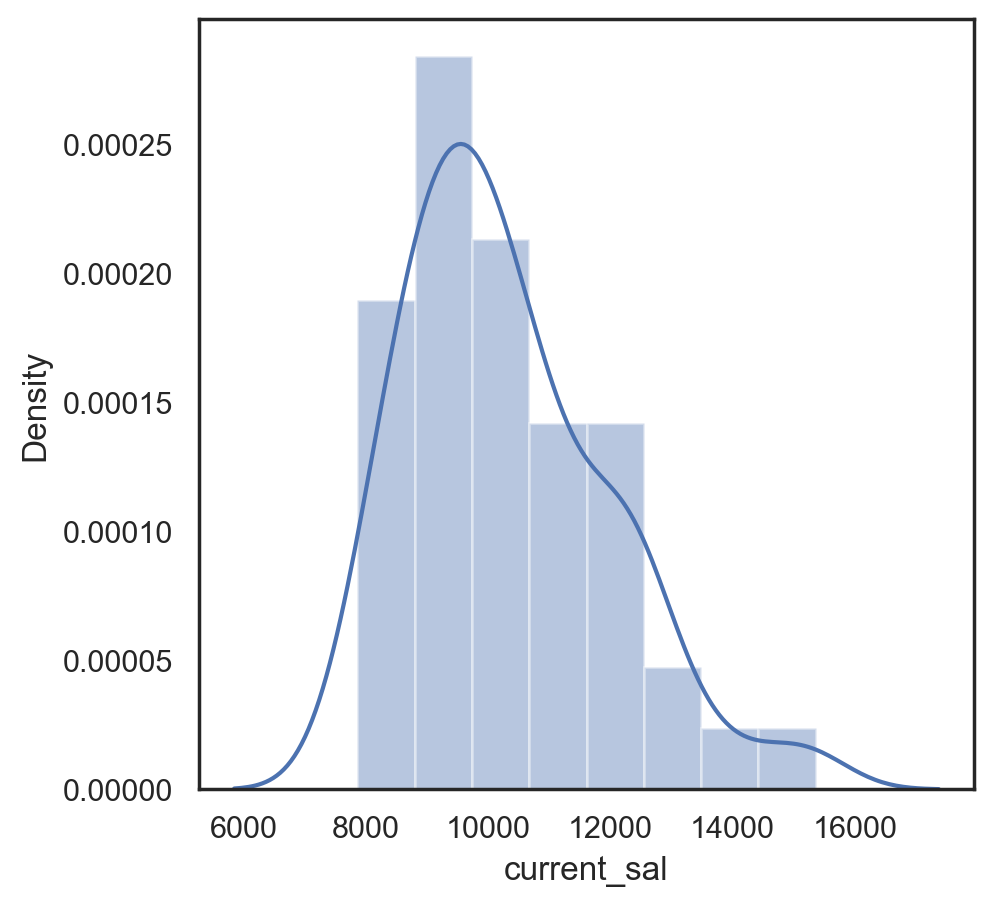

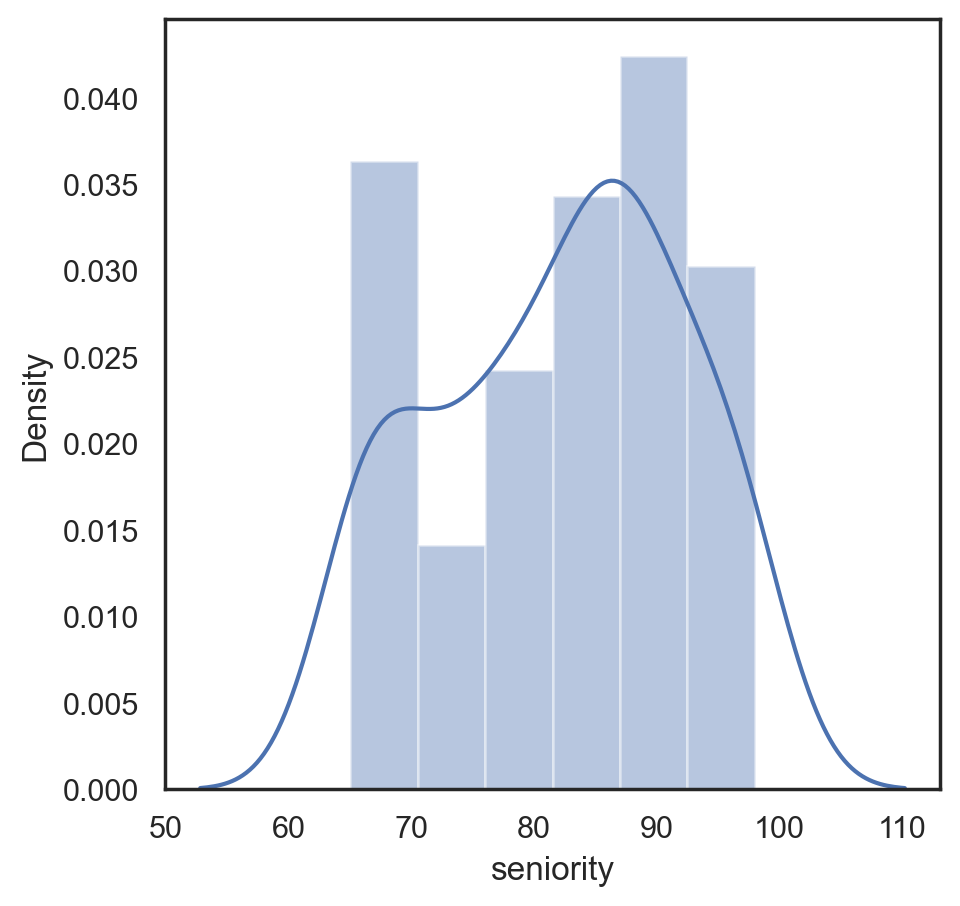

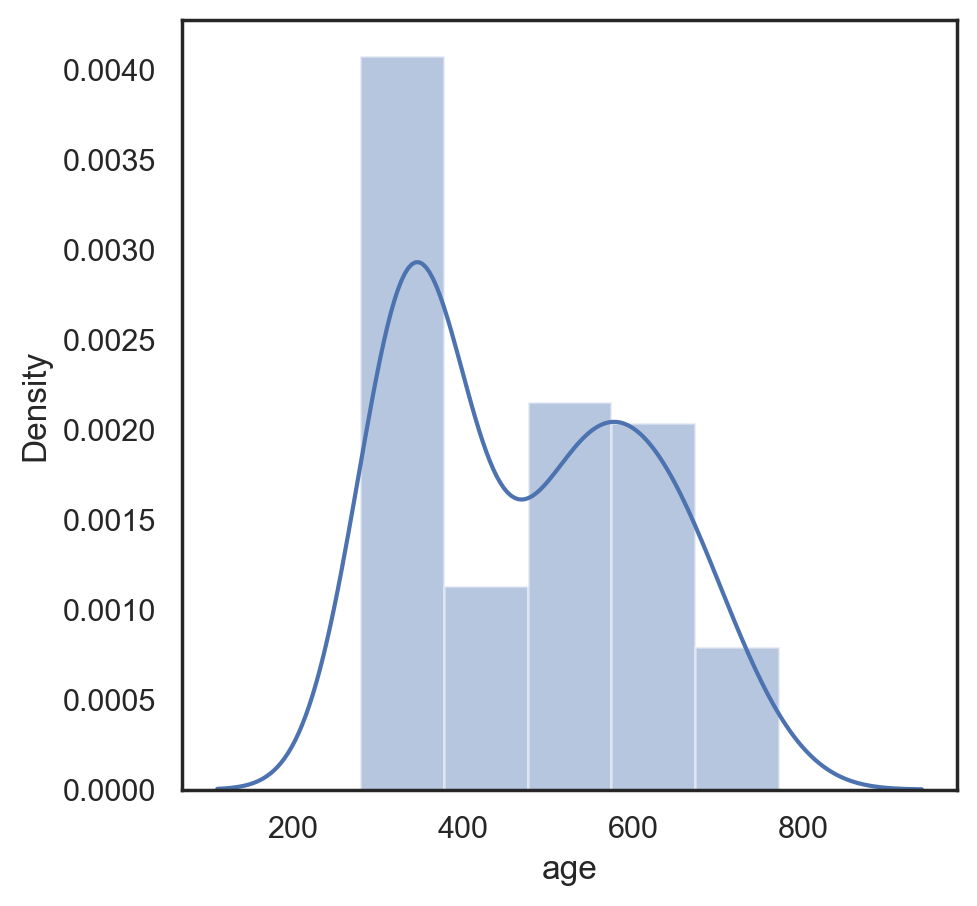

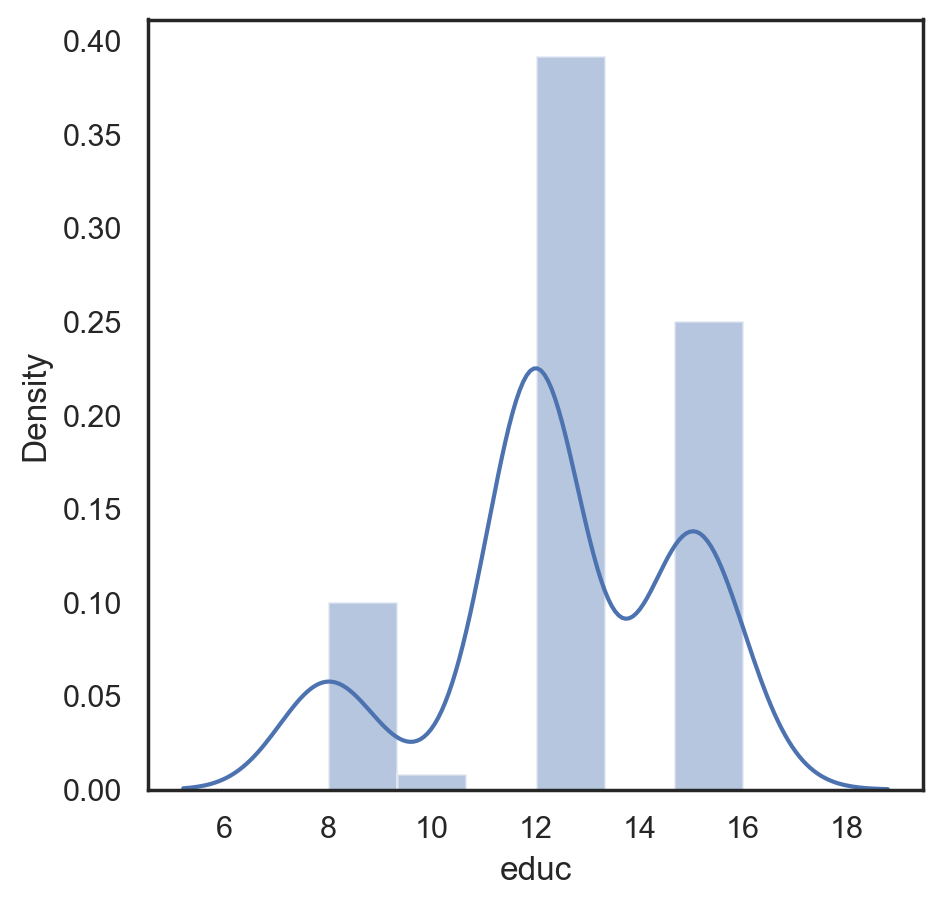

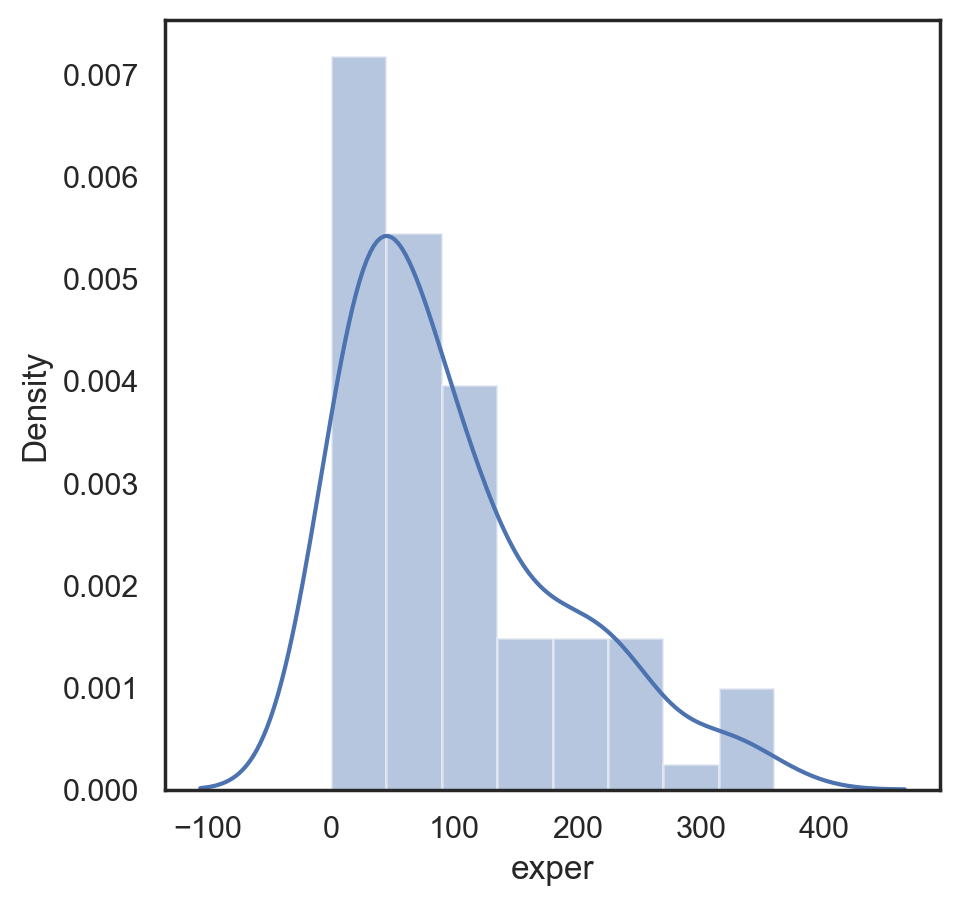

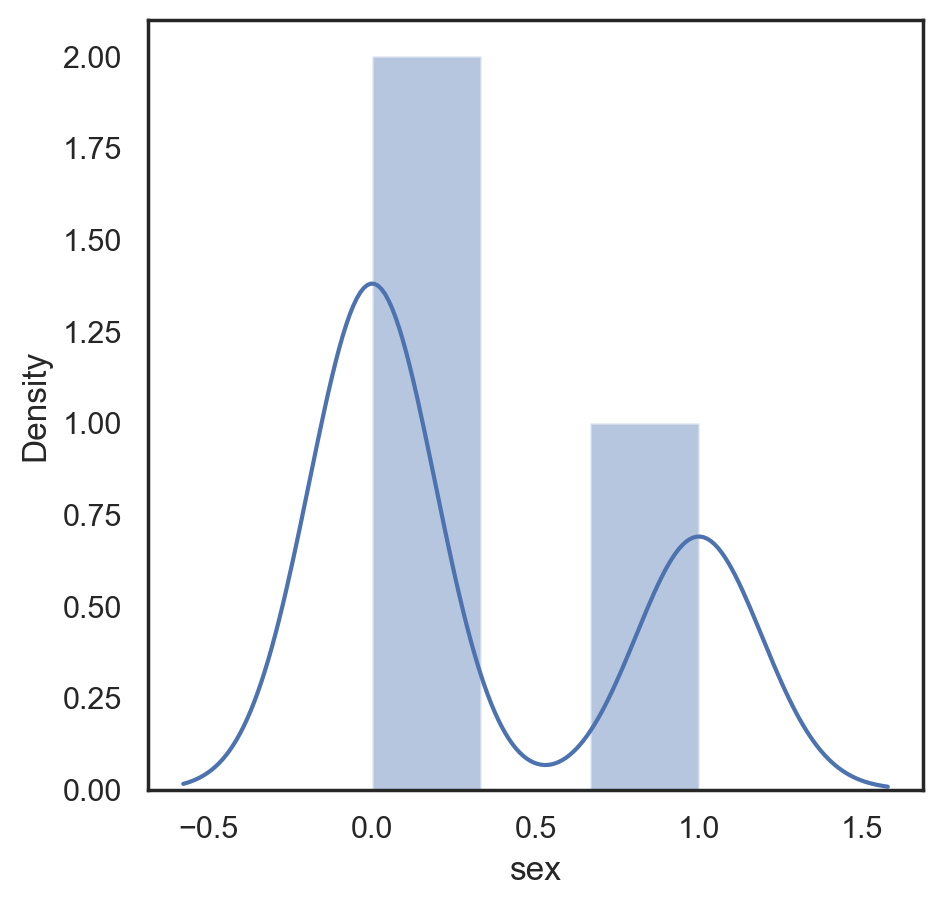

In [12]:
#distribution of ordinal and continuous variables

for i, name in enumerate(df.columns):
    plt.figure(i,figsize=(5,5))
    sns.distplot(df[name])
    

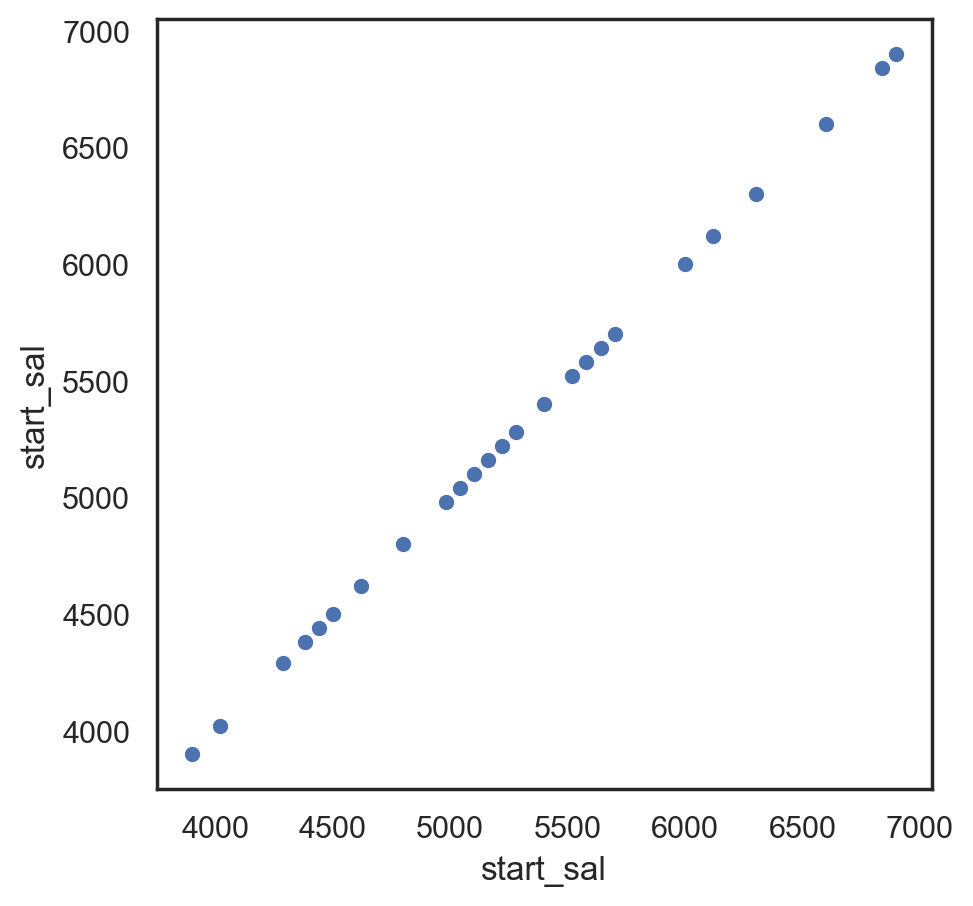

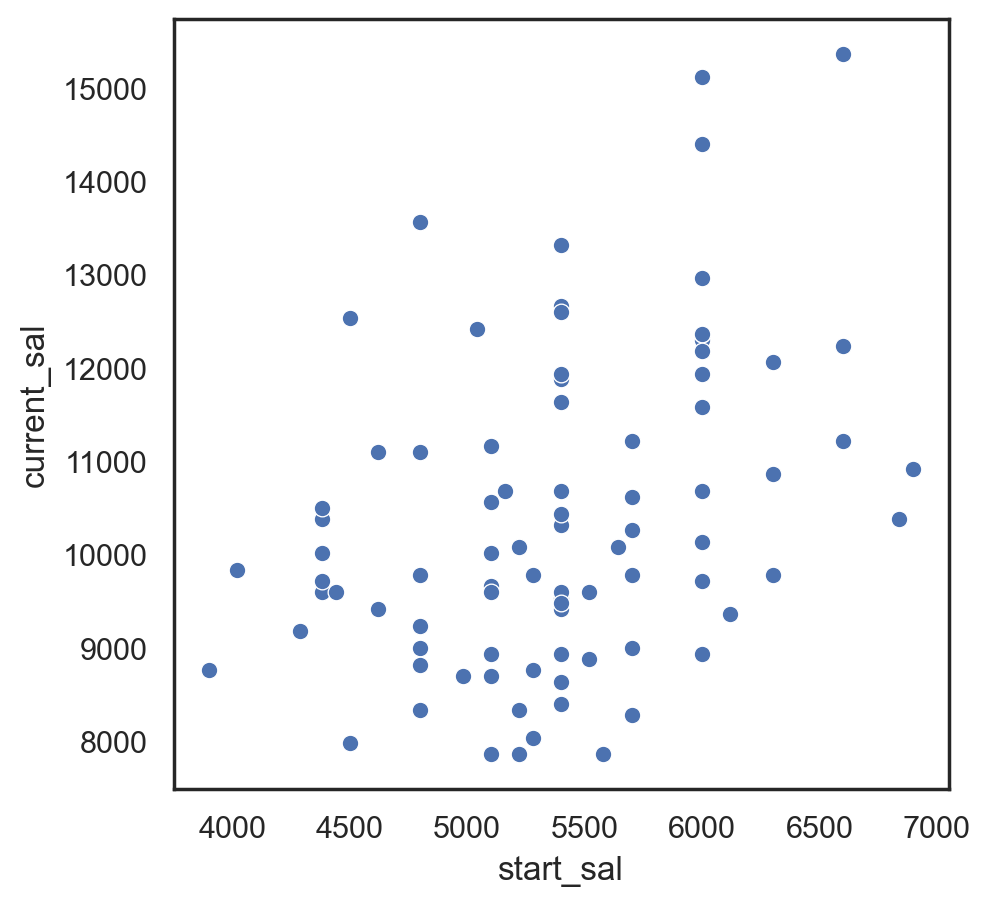

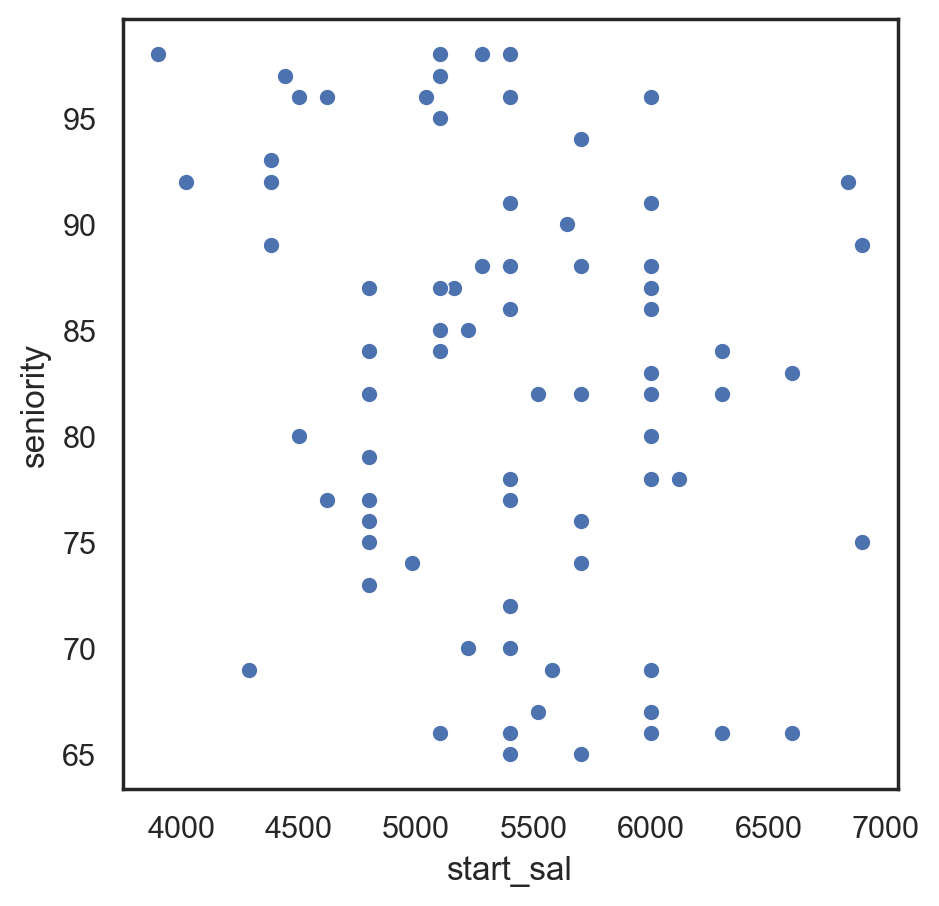

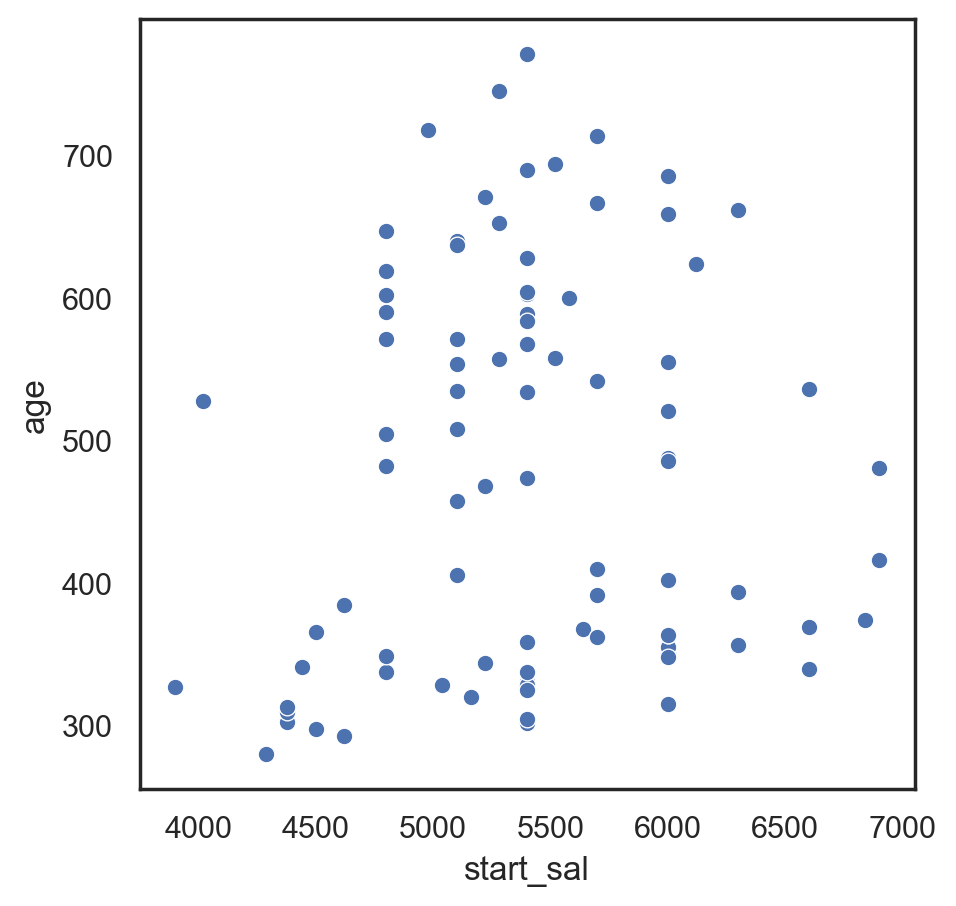

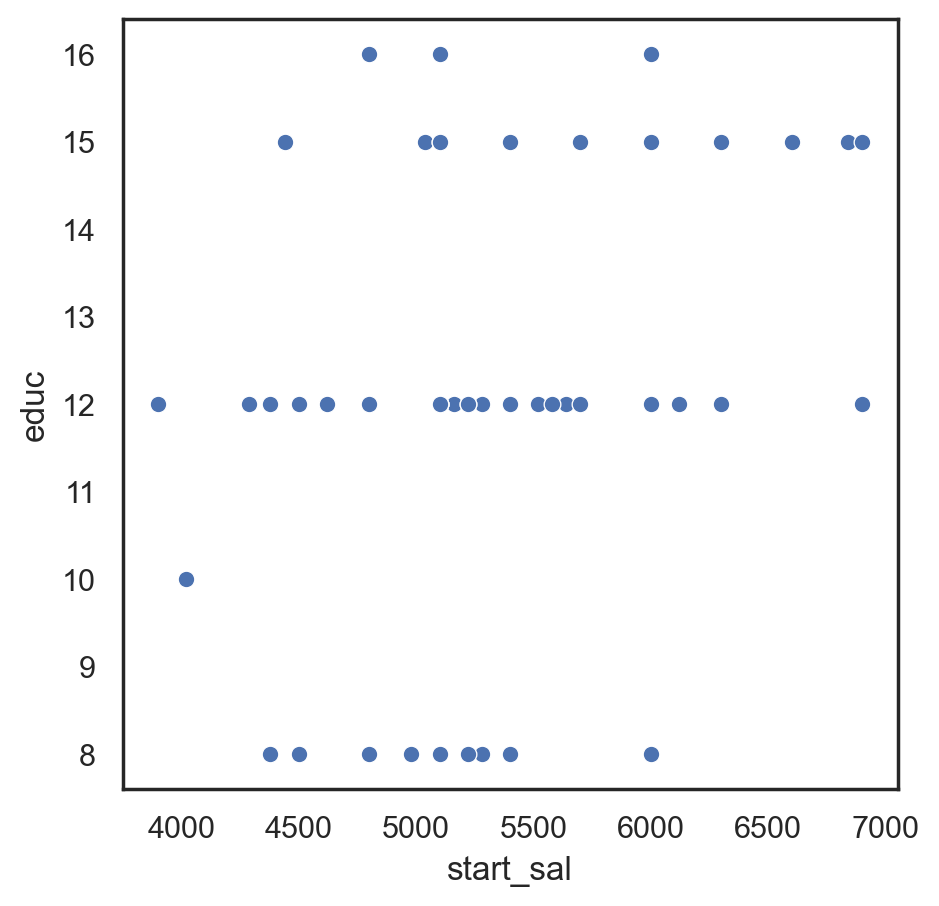

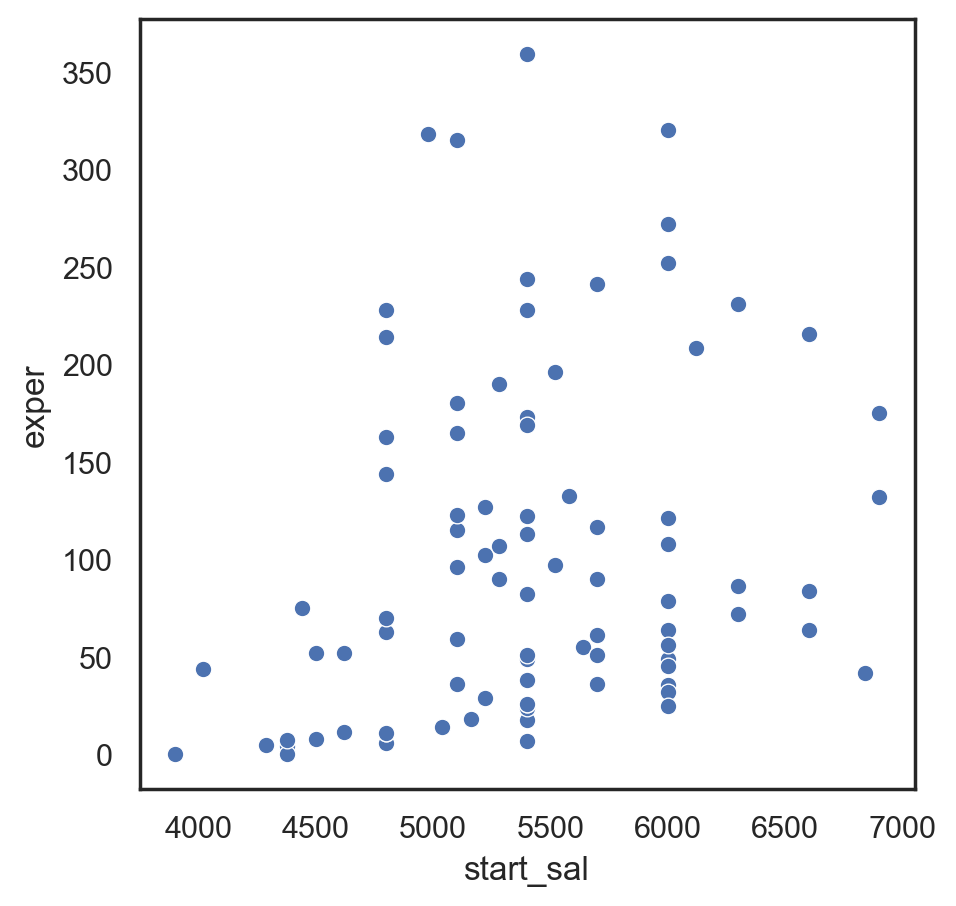

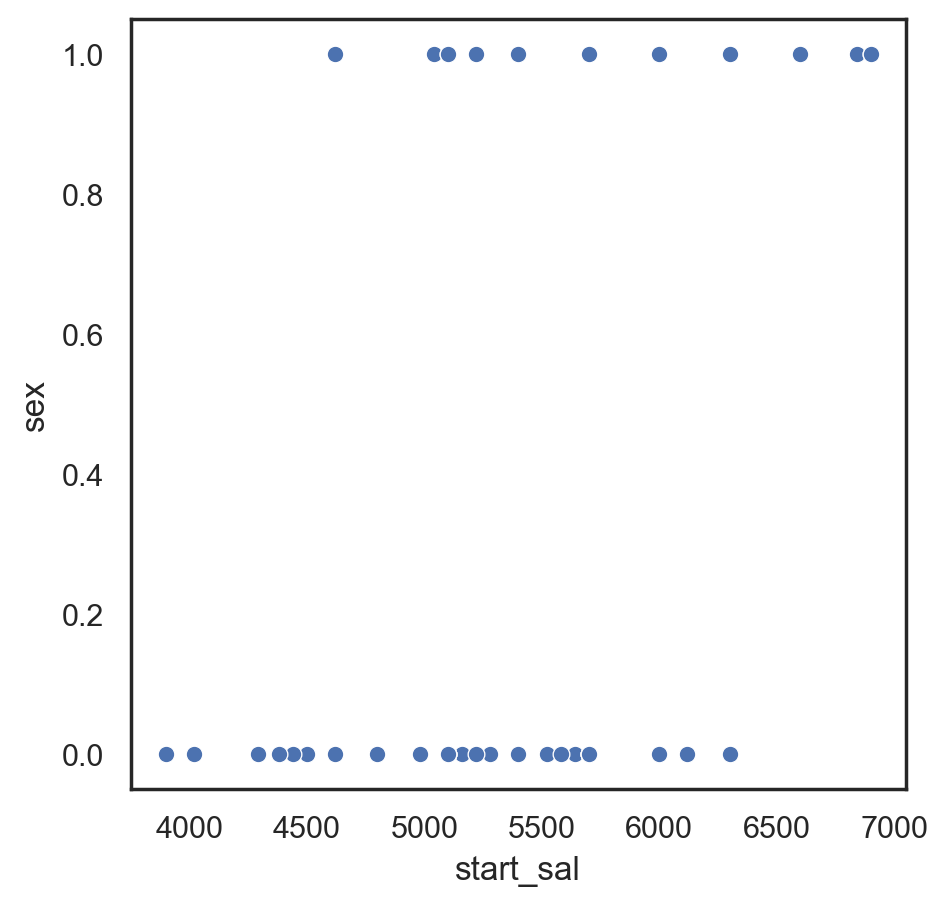

In [13]:
for i, name in enumerate(df.columns):
    plt.figure(i,figsize=(5,5))
    sns.scatterplot(data=df, x="start_sal", y=name)
    

In [14]:
#experience looks like a quadratic curve

df["exp2"]=df['exper']*df['exper']
df.head(3)

,start_sal,current_sal,seniority,age,educ,exper,sex,exp2
0,5040.0,12420.0,96.0,329.0,15.0,14.0,1,196.00
1,6300.0,12060.0,82.0,357.0,15.0,72.0,1,5184.00
2,6000.0,15120.0,67.0,315.0,15.0,35.5,1,1260.25


<Axes: xlabel='start_sal', ylabel='exp2'>

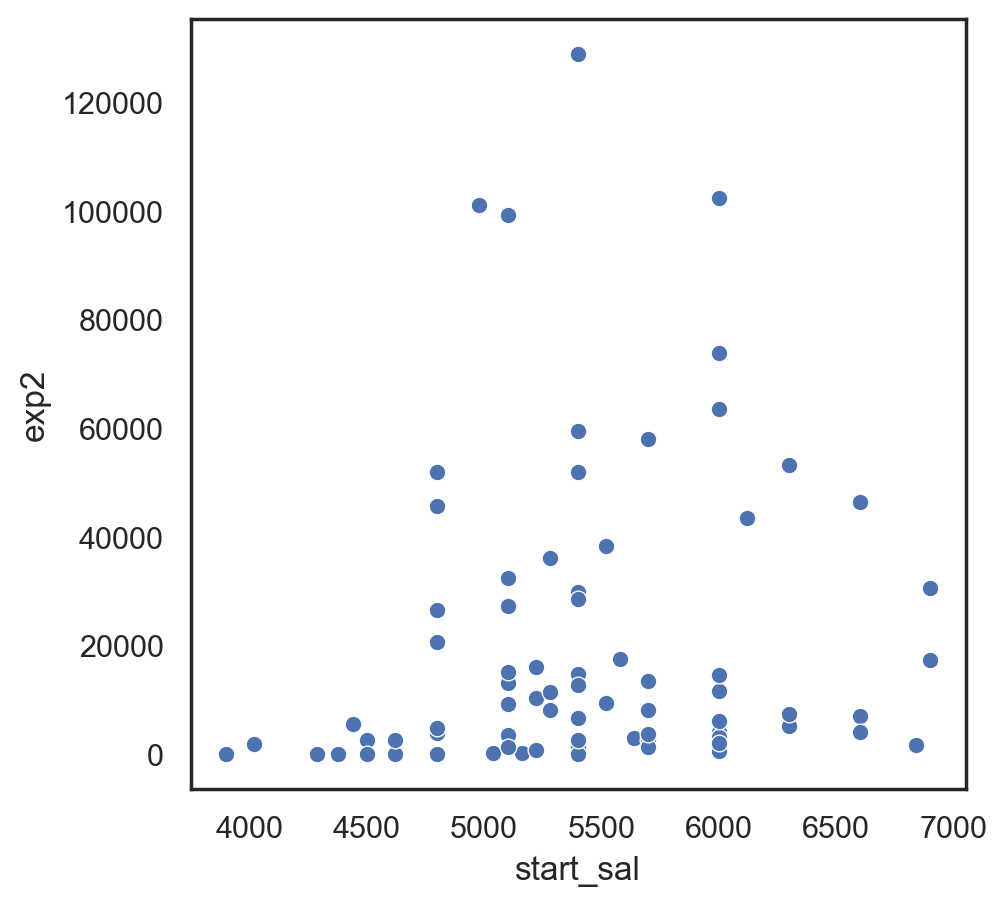

In [15]:
plt.figure(i,figsize=(5,5))
sns.scatterplot(data=df, x="start_sal", y='exp2')

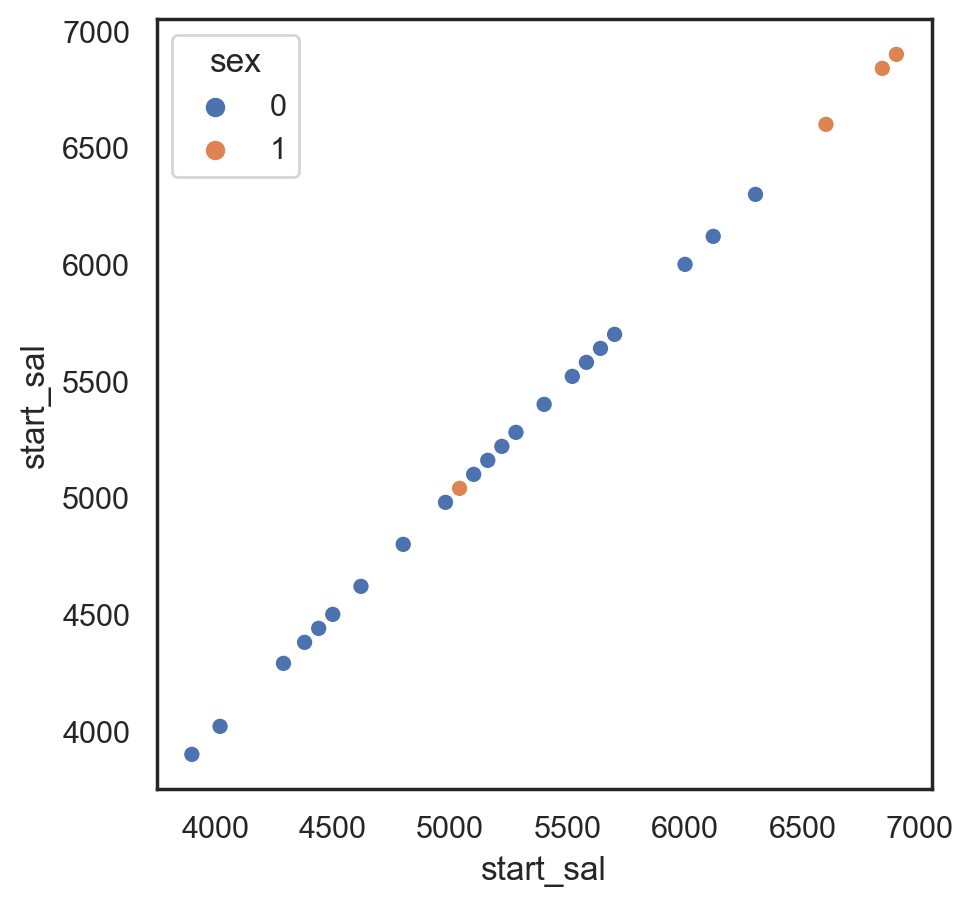

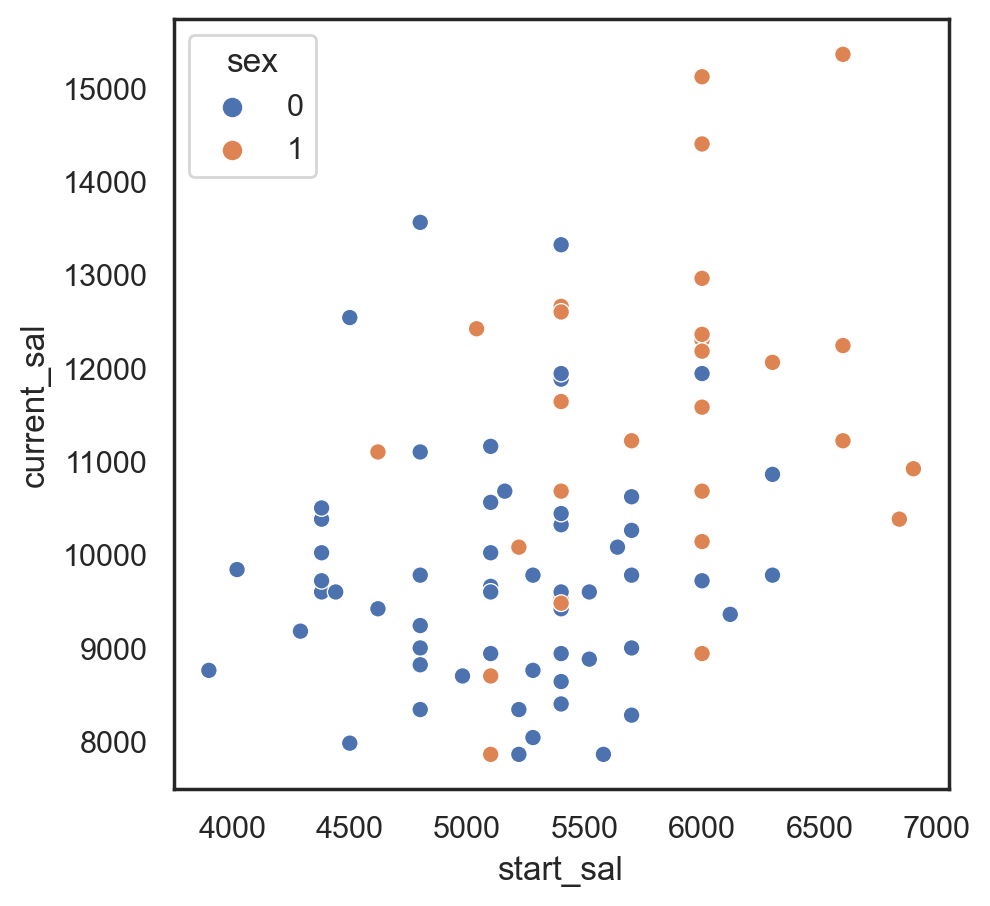

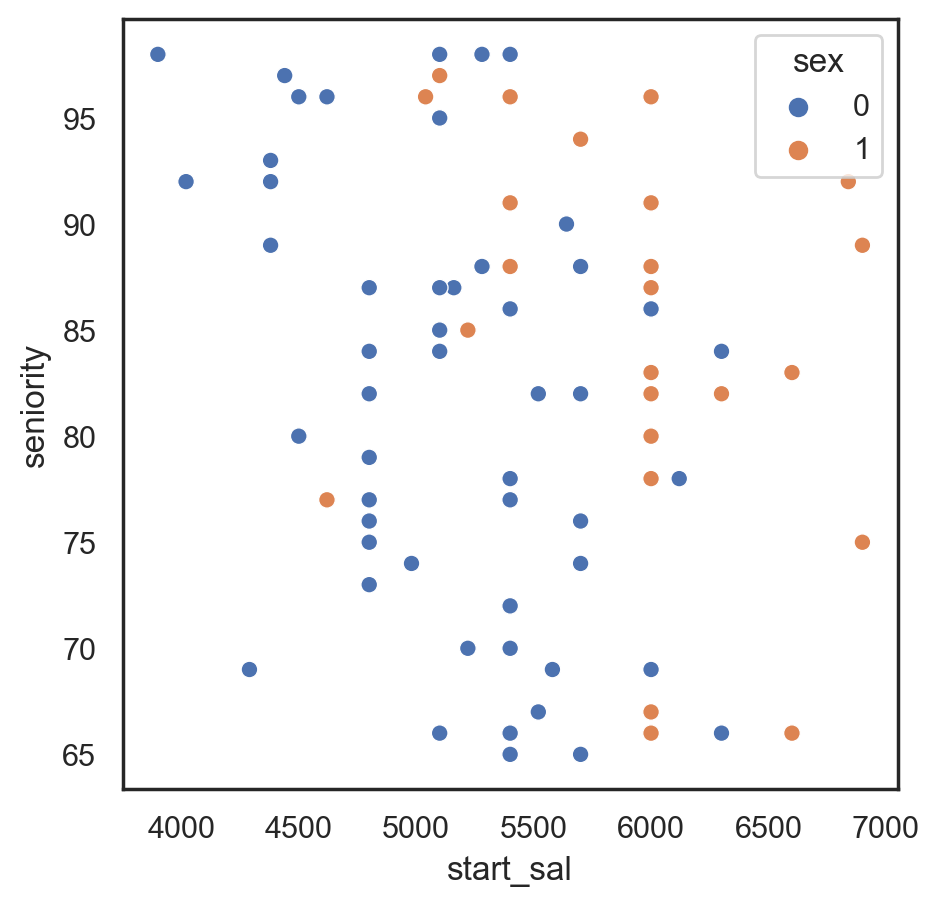

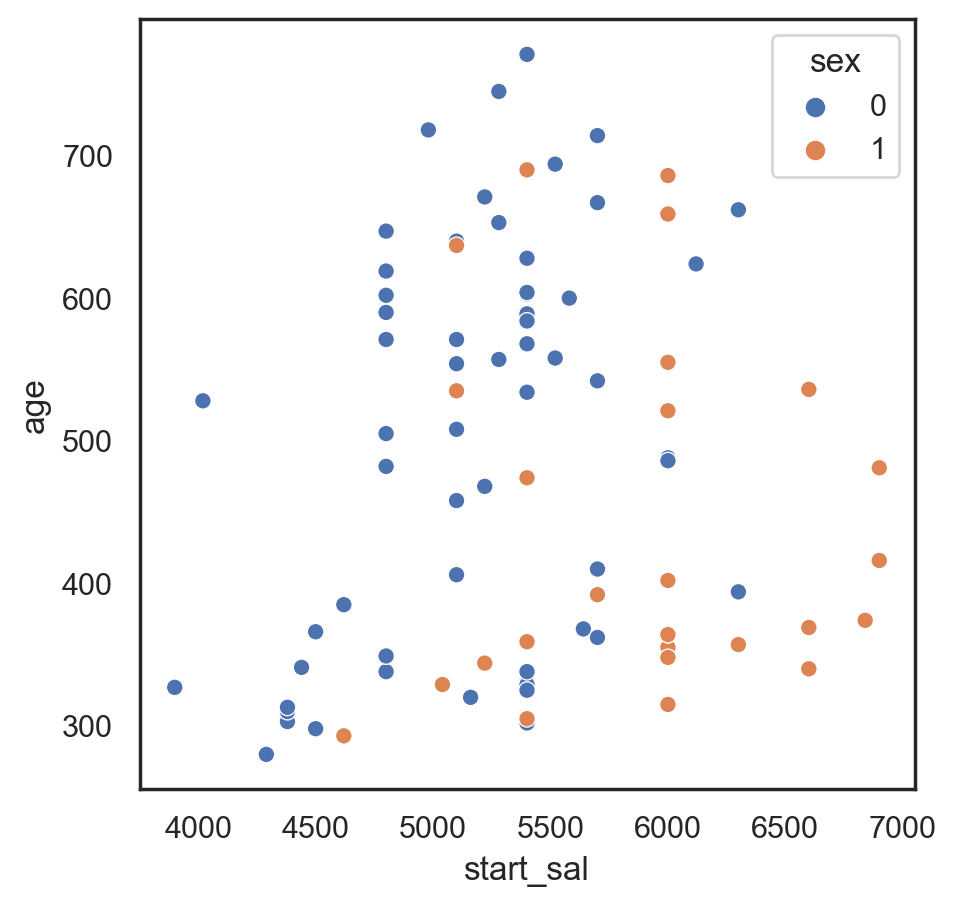

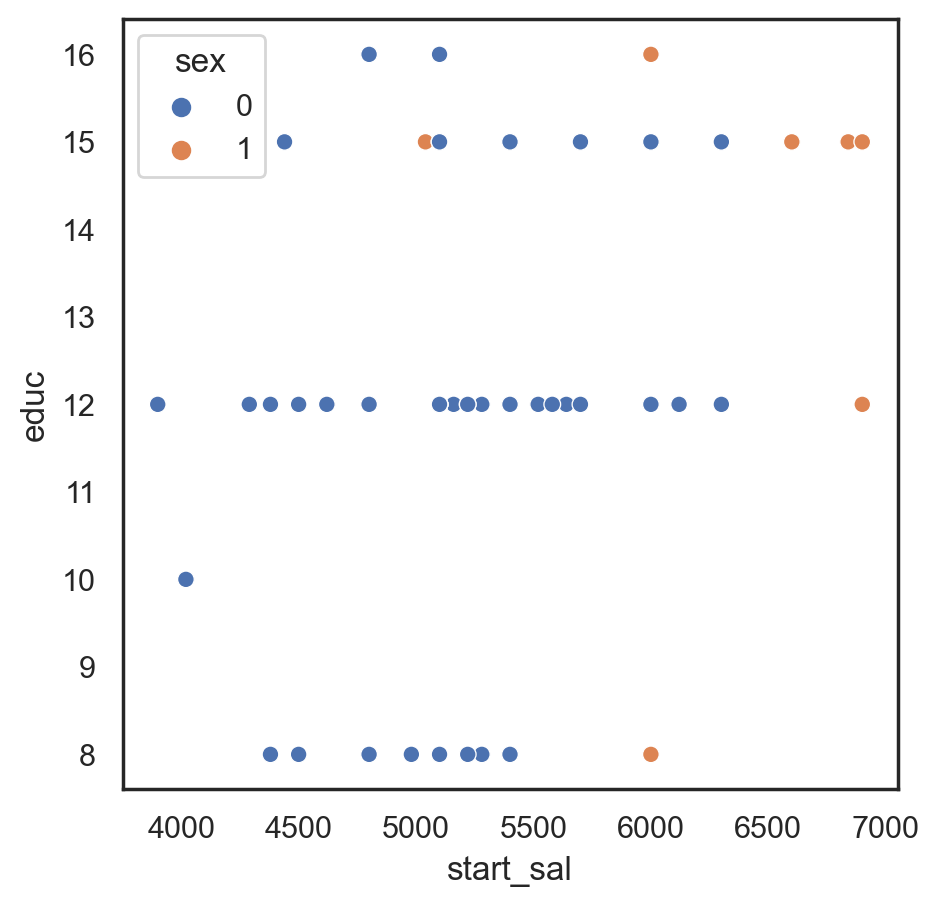

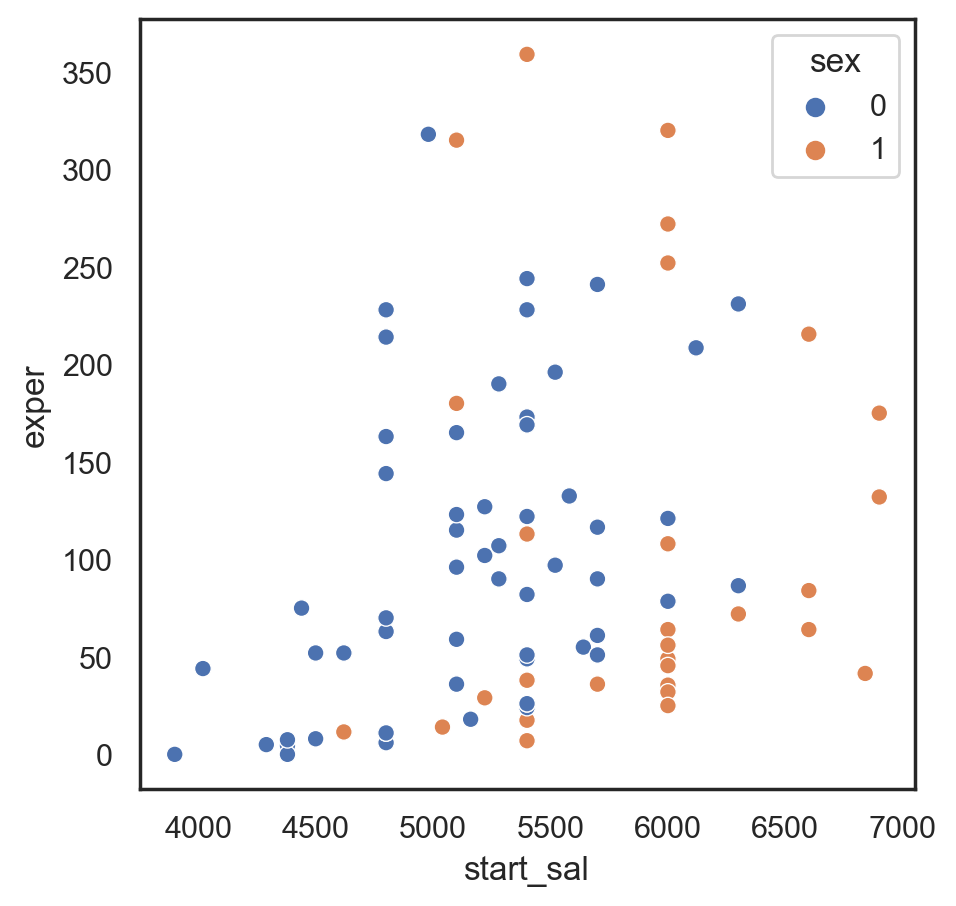

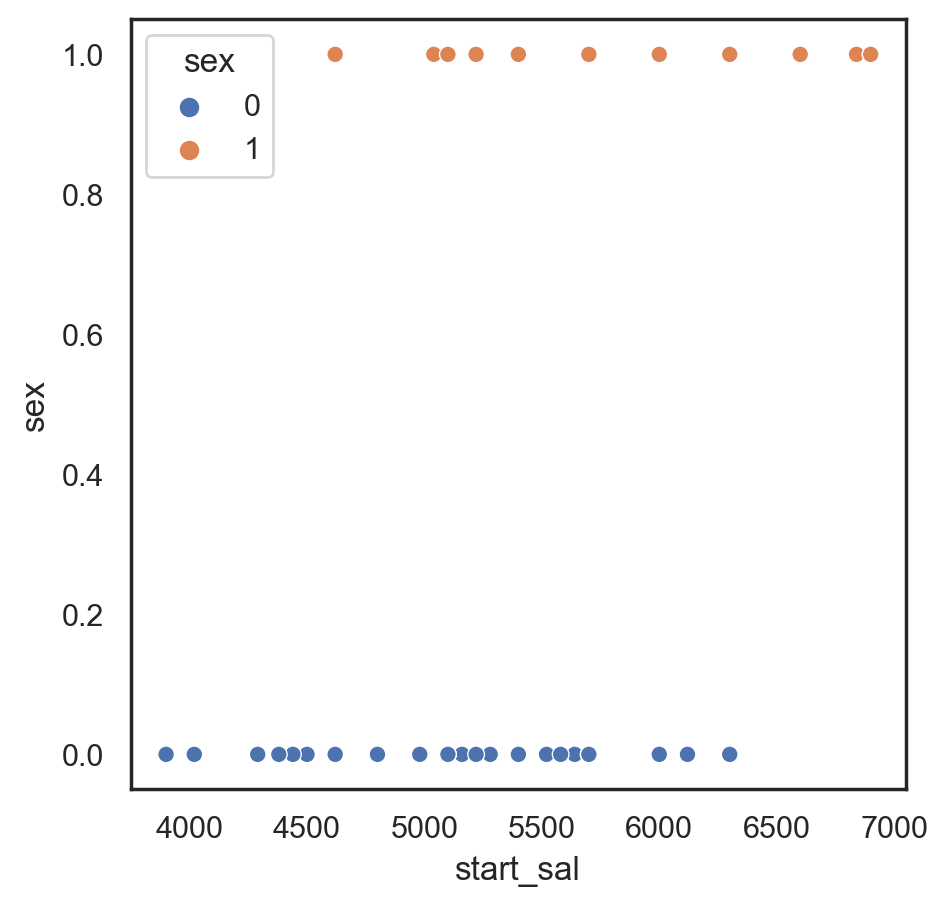

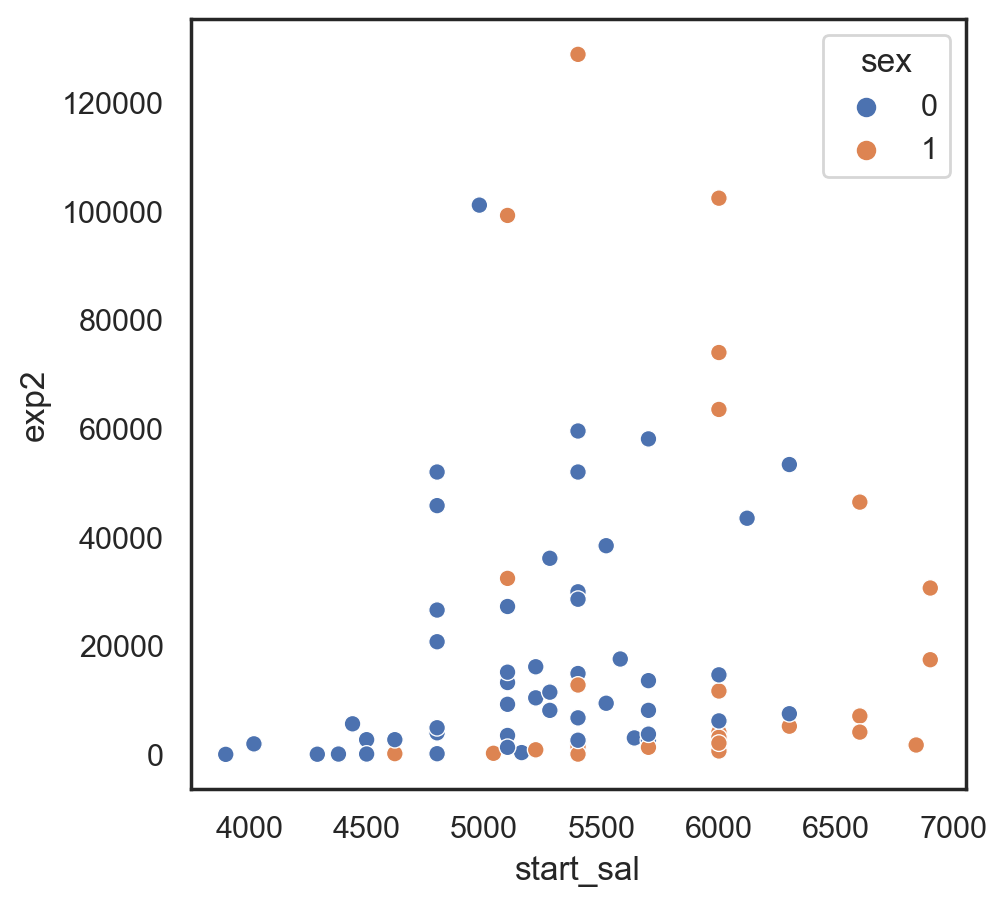

In [16]:
for i, name in enumerate(df.columns):
    plt.figure(i,figsize=(5,5))
    sns.scatterplot(data=df, x="start_sal", y=name, hue = "sex")

# Regression

In [17]:
df.columns

Index(['start_sal', 'current_sal', 'seniority', 'age', 'educ', 'exper', 'sex',
       'exp2'],
      dtype='object')

In [18]:
x_full = df[['educ', 'exper', 'exp2', 'sex']].values
x_full = sm.add_constant(x_full)

x_nested = df[['educ', 'exper', 'exp2']].values
x_nested = sm.add_constant(x_nested)

y = df[['start_sal']]


In [19]:
# Fit the full and nested models
model_full = sm.OLS(y, x_full).fit()
model_nested = sm.OLS(y, x_nested).fit()

In [21]:
print("\nNested Model Summary:")
print(model_nested.summary())


Nested Model Summary:
                            OLS Regression Results                            
Dep. Variable:              start_sal   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     12.65
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           6.33e-07
Time:                        09:26:56   Log-Likelihood:                -694.56
No. Observations:                  90   AIC:                             1397.
Df Residuals:                      86   BIC:                             1407.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3541.8532    344.

In [20]:
# Print model summaries
print("Full Model Summary:")
print(model_full.summary())


Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:              start_sal   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     24.77
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.30e-13
Time:                        09:26:56   Log-Likelihood:                -676.23
No. Observations:                  90   AIC:                             1362.
Df Residuals:                      85   BIC:                             1375.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3889.3081    287.400

# R2 change

So here is the interesting part. In our case, the r2 scores jumped by about 20% more explained variance. In some cases, there may not be such a big jump. How then shall we know if this variable/covariate explain enough unique variance to be kept in the model. 

In this case, we need to conduct a hypothesis test to test that these r2 scores are indeed different. We can use the formula below to perform an F-test!


$$
 F = \frac{(R2 full - R2 nested)/(k full - k nested)}{(1-R2 full )/(n - k full - 1))}
$$

- R2 full = R-square full model
- R2 nested = R-square nested model
- k full = k number of predictors in full model
- k nested = k number of predictors in nested model
- n = Sample size

In our case, Sex is a significant predictor of starting salary and adding Sex into the model after controlling for experiencce and education, significantly explain a higher proportion of variance in starting pay.

In [22]:
# Calculate R-squared for the full and nested models
r2_full = model_full.rsquared
r2_nested = model_nested.rsquared

# Calculate the F-statistic and p-value
n_full, k_full = x_full.shape
n_nested, k_nested = x_nested.shape

numerator = (r2_full - r2_nested) / (k_full - k_nested)
denominator = (1 - r2_full) / (n_full - k_full - 1)

f_statistic = numerator / denominator
p_value = f.sf(f_statistic, k_full - k_nested, n_full - k_full - 1)

In [23]:
# Print R-squared change F-statistic and p-value
print("\nR-squared Change F-statistic:", f_statistic)
print("p-value:", p_value)


R-squared Change F-statistic: 42.231677813006215
p-value: 5.462596847269686e-09


## In closing:

The article shares a way to calculate if an R square change is significant between 2 nested model using an F-test. This is important in the decision to keep the parsimonious model versus the full model.
The significance of the change in R square is often used in hierarchical regressions, forward/backward selections, models with covariates or any other nested models, together with other metrics.